## Imports

In [21]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import feature_extraction, linear_model, model_selection, preprocessing
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline

from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.preprocessing import LabelEncoder

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

import nltk
import nltk as nlp
import string
import re
from wordcloud import WordCloud
import pickle

## Dataset

In [27]:
# Load both csv's
true_df = pd.read_csv("fake-and-real-news-dataset/True.csv")
fake_df = pd.read_csv("fake-and-real-news-dataset/Fake.csv")

In [264]:
# add target identifiers to differentiate fakes and trues 
fake_df['target'] = 'fake'
true_df['target'] = 'true'

# merge the two dataframes into one
news = pd.concat([fake_df, true_df]).reset_index(drop = True)

## Exploratory Data Analysis

In [45]:
true_df.head()

title  \
0  As U.S. budget fight looms, Republicans flip t...   
1  U.S. military to accept transgender recruits o...   
2  Senior U.S. Republican senator: 'Let Mr. Muell...   
3  FBI Russia probe helped by Australian diplomat...   
4  Trump wants Postal Service to charge 'much mor...   

                                                text       subject  \
0  WASHINGTON (Reuters) - The head of a conservat...  politicsNews   
1  WASHINGTON (Reuters) - Transgender people will...  politicsNews   
2  WASHINGTON (Reuters) - The special counsel inv...  politicsNews   
3  WASHINGTON (Reuters) - Trump campaign adviser ...  politicsNews   
4  SEATTLE/WASHINGTON (Reuters) - President Donal...  politicsNews   

                 date  
0  December 31, 2017   
1  December 29, 2017   
2  December 31, 2017   
3  December 30, 2017   
4  December 29, 2017

In [343]:
fake_df.head()

title  \
0   Donald Trump Sends Out Embarrassing New Year’...   
1   Drunk Bragging Trump Staffer Started Russian ...   
2   Sheriff David Clarke Becomes An Internet Joke...   
3   Trump Is So Obsessed He Even Has Obama’s Name...   
4   Pope Francis Just Called Out Donald Trump Dur...   

                                                text subject  \
0  Donald Trump just couldn t wish all Americans ...    News   
1  House Intelligence Committee Chairman Devin Nu...    News   
2  On Friday, it was revealed that former Milwauk...    News   
3  On Christmas day, Donald Trump announced that ...    News   
4  Pope Francis used his annual Christmas Day mes...    News   

                date target  
0  December 31, 2017   fake  
1  December 31, 2017   fake  
2  December 30, 2017   fake  
3  December 29, 2017   fake  
4  December 25, 2017   fake

In [346]:
news.head()

title  \
0   Donald Trump Sends Out Embarrassing New Year’...   
1   Drunk Bragging Trump Staffer Started Russian ...   
2   Sheriff David Clarke Becomes An Internet Joke...   
3   Trump Is So Obsessed He Even Has Obama’s Name...   
4   Pope Francis Just Called Out Donald Trump Dur...   

                                                text subject  \
0  Donald Trump just couldn t wish all Americans ...    News   
1  House Intelligence Committee Chairman Devin Nu...    News   
2  On Friday, it was revealed that former Milwauk...    News   
3  On Christmas day, Donald Trump announced that ...    News   
4  Pope Francis used his annual Christmas Day mes...    News   

                date target  
0  December 31, 2017   fake  
1  December 31, 2017   fake  
2  December 30, 2017   fake  
3  December 29, 2017   fake  
4  December 25, 2017   fake

In [347]:
news.tail()

title  \
44893  'Fully committed' NATO backs new U.S. approach...   
44894  LexisNexis withdrew two products from Chinese ...   
44895  Minsk cultural hub becomes haven from authorities   
44896  Vatican upbeat on possibility of Pope Francis ...   
44897  Indonesia to buy $1.14 billion worth of Russia...   

                                                    text    subject  \
44893  BRUSSELS (Reuters) - NATO allies on Tuesday we...  worldnews   
44894  LONDON (Reuters) - LexisNexis, a provider of l...  worldnews   
44895  MINSK (Reuters) - In the shadow of disused Sov...  worldnews   
44896  MOSCOW (Reuters) - Vatican Secretary of State ...  worldnews   
44897  JAKARTA (Reuters) - Indonesia will buy 11 Sukh...  worldnews   

                   date target  
44893  August 22, 2017    true  
44894  August 22, 2017    true  
44895  August 22, 2017    true  
44896  August 22, 2017    true  
44897  August 22, 2017    true

In [285]:
# see the available columns
list(news)

['title', 'text', 'subject', 'date', 'target']

In [286]:
# count target values
news.target.value_counts()

fake    23481
true    21417
Name: target, dtype: int64

In [287]:
# Describe dataset
news.describe()

title   text  \
count                                               44898  44898   
unique                                              38729  38646   
top     Factbox: Trump fills top jobs for his administ...          
freq                                                   14    627   

             subject                date target  
count          44898               44898  44898  
unique             8                2397      2  
top     politicsNews  December 20, 2017    fake  
freq           11272                 182  23481

In [288]:
# Describe the different targets
news.groupby('target').describe()

title                                                                 \
        count unique                                                top freq   
target                                                                         
fake    23481  17903  MEDIA IGNORES Time That Bill Clinton FIRED His...    6   
true    21417  20826  Factbox: Trump fills top jobs for his administ...   14   

         text                                                                 \
        count unique                                                top freq   
target                                                                         
fake    23481  17455                                                     626   
true    21417  21192  (Reuters) - Highlights for U.S. President Dona...    8   

       subject                               date                             \
         count unique           top   freq  count unique                 top   
target                                                                         
fake     23481      6          News   9050  23481   1681        May 10, 2017   
true     21417      2  politicsNews  11272  21417    716  December 20, 2017    

             
       freq  
target       
fake     46  
true    182

In [289]:
# Display news subjects for fakes
print("Fake news subjects:")
for key, count in fake_df.subject.value_counts().iteritems():
    print(f"* {key}: {count}")
    
# Display total subject amount
print(f"Total Subject Amount: {fake_df.shape[0]}")

Fake news subjects:
* News: 9050
* politics: 6841
* left-news: 4459
* Government News: 1570
* US_News: 783
* Middle-east: 778
Total Subject Amount: 23481


In [290]:
# Display news subjects for trues
print("True news subjects:")
for key, count in true_df.subject.value_counts().iteritems():
    print(f"* {key}: {count}")
    
# Display total subject amount
print(f"Total Subject Amount: {true_df.shape[0]}")

True news subjects:
* politicsNews: 11272
* worldnews: 10145
Total Subject Amount: 21417


## Data Visualization

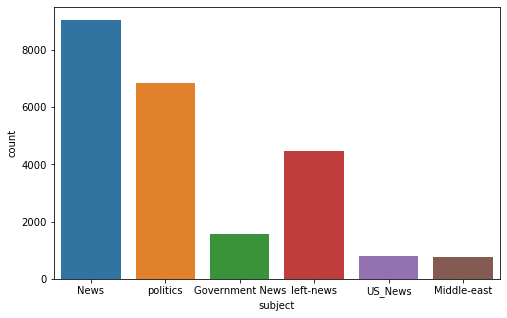

In [275]:
# plot subjects for fakes
plt.figure(figsize=(8,5))
sns.countplot("subject", data=fake_df)
plt.show()

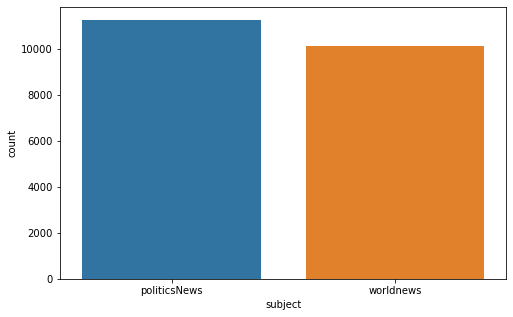

In [276]:
# Plot subjects for true
plt.figure(figsize=(8,5))
sns.countplot("subject", data=true_df)
plt.show()

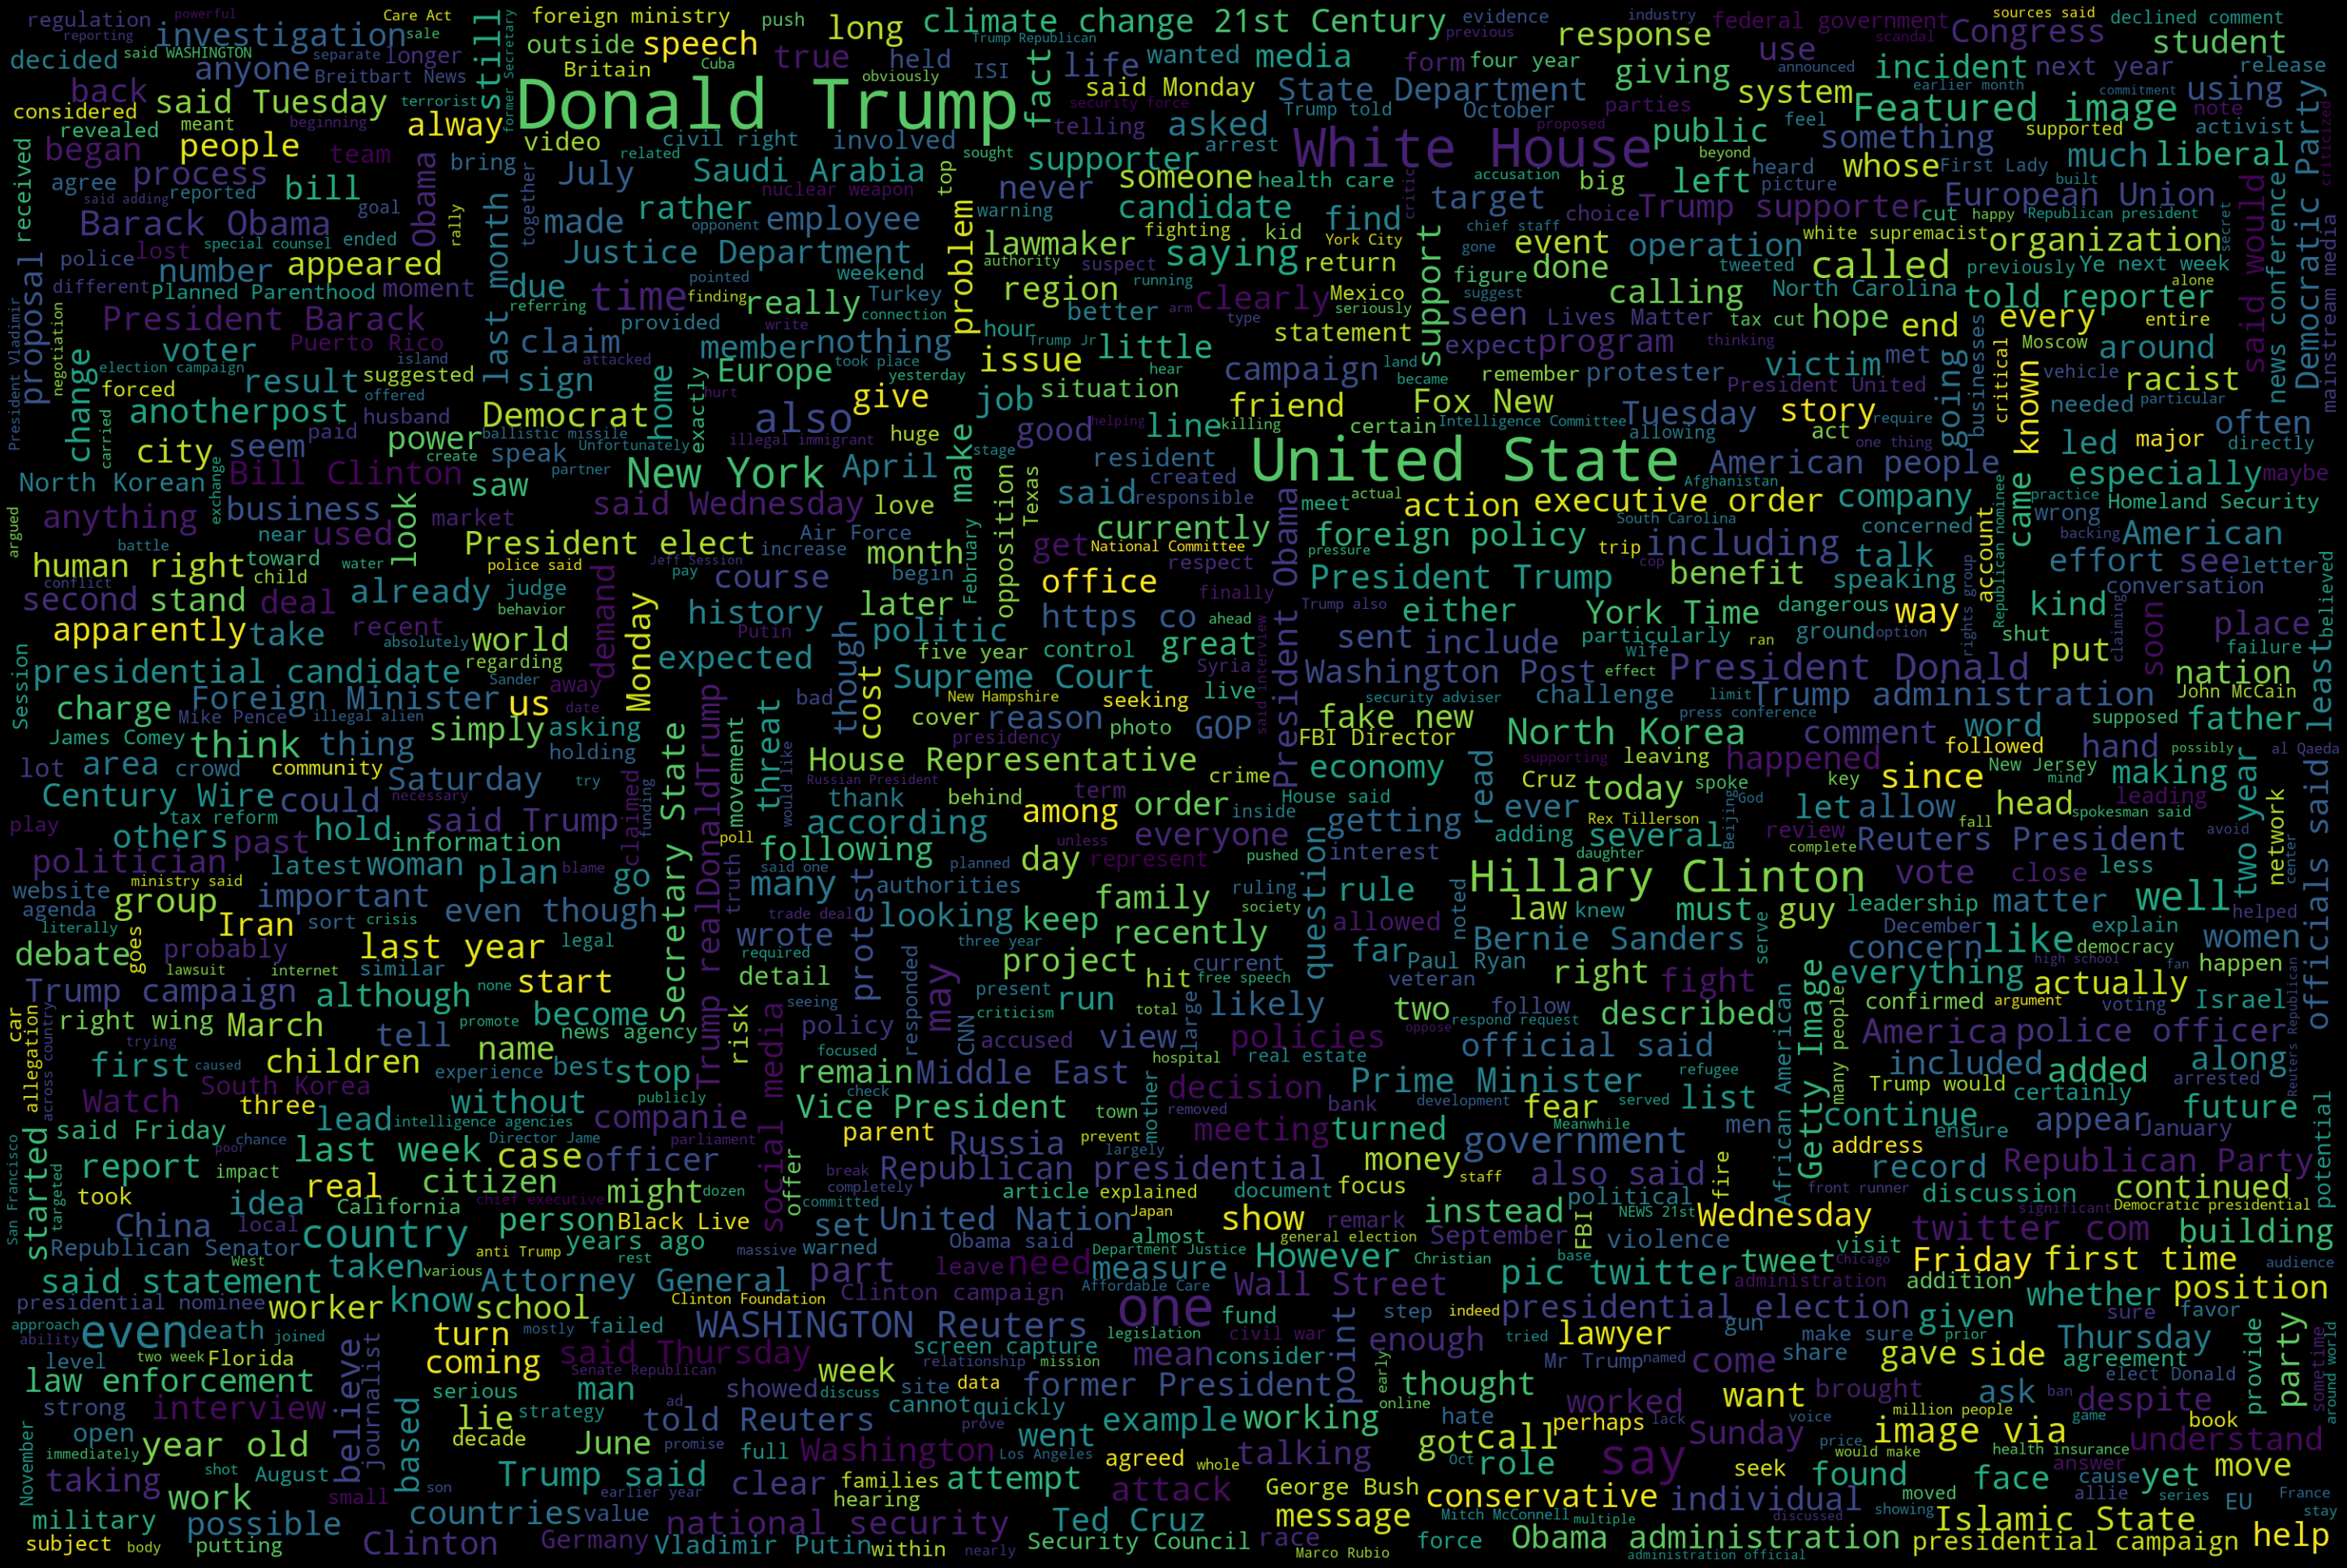

In [6]:
# Generate wordcloud displaying the most common words used in the news
text = " ".join(text for text in news.text)

wordcloud = WordCloud(
background_color="black",
width = 3000,
height = 2000,
max_words=1000,
max_font_size=90,
stopwords = set(nltk.corpus.stopwords.words("english")),
random_state=42).generate(text)
fig = plt.figure(
    figsize = (40, 30),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

## Training Data

In [292]:
Y = news.target
# X = news.title
# X = news.subject
# X = news.date
X = news.text
test_size = 0.20
random_state = 200

# Creating and training data
x_train,x_test,y_train,y_test = train_test_split(X, Y, test_size=test_size, random_state=random_state)

In [293]:
# Creating and training data
x_train,x_test,y_train,y_test = train_test_split(X, Y, test_size=test_size, random_state=random_state)

## Multinomial Naive Bayes Classifier

In [294]:
pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', MultinomialNB())])

model = pipe.fit(x_train, y_train)
prediction = model.predict(x_test)
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))

accuracy: 93.65%


In [295]:
mnbc_score = round(accuracy_score(y_test, prediction)*100,2)
mnbc_score

93.65

In [296]:
print(confusion_matrix(y_test, prediction))

[[4454  241]
 [ 329 3956]]


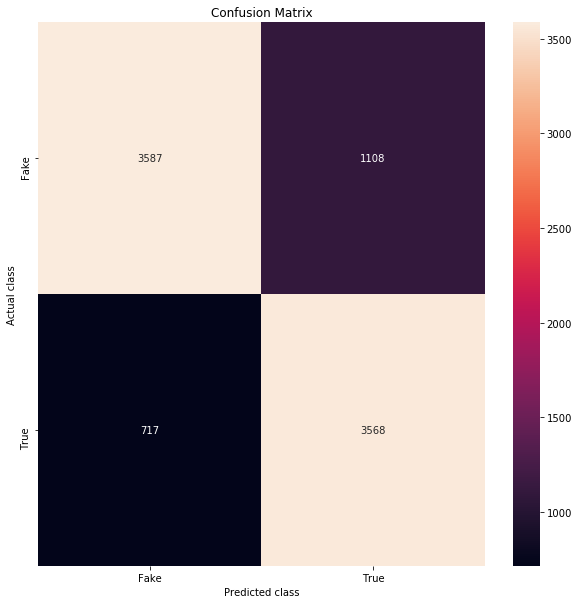

In [189]:
LABELS = ['Fake', 'True'] 
conf_matrix = confusion_matrix(y_test, prediction) 
plt.figure(figsize =(10, 10)) 
sns.heatmap(conf_matrix, xticklabels = LABELS, 
yticklabels = LABELS, annot = True, fmt ="d"); 
plt.title("Confusion Matrix") 
plt.ylabel('Actual class') 
plt.xlabel('Predicted class') 
plt.show()

In [190]:
print(classification_report(y_test, prediction))

              precision    recall  f1-score   support

        fake       0.83      0.76      0.80      4695
        true       0.76      0.83      0.80      4285

    accuracy                           0.80      8980
   macro avg       0.80      0.80      0.80      8980
weighted avg       0.80      0.80      0.80      8980



## Bernoulli Naive Bayes Classifier

In [191]:
pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', BernoulliNB())])

model = pipe.fit(x_train, y_train)
prediction = model.predict(x_test)
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))

accuracy: 79.37%


In [192]:
bnbc_score = round(accuracy_score(y_test, prediction)*100,2)
bnbc_score

79.37

In [193]:
print(confusion_matrix(y_test, prediction))

[[3658 1037]
 [ 816 3469]]


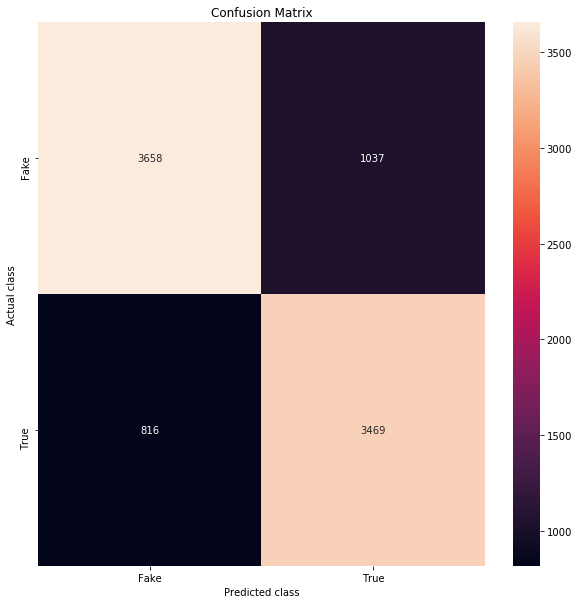

In [194]:
LABELS = ['Fake', 'True'] 
conf_matrix = confusion_matrix(y_test, prediction) 
plt.figure(figsize =(10, 10)) 
sns.heatmap(conf_matrix, xticklabels = LABELS, 
yticklabels = LABELS, annot = True, fmt ="d"); 
plt.title("Confusion Matrix") 
plt.ylabel('Actual class') 
plt.xlabel('Predicted class') 
plt.show()

In [195]:
print(classification_report(y_test, prediction))

              precision    recall  f1-score   support

        fake       0.82      0.78      0.80      4695
        true       0.77      0.81      0.79      4285

    accuracy                           0.79      8980
   macro avg       0.79      0.79      0.79      8980
weighted avg       0.79      0.79      0.79      8980



## Decision Tree

In [322]:
pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', DecisionTreeClassifier(criterion= 'entropy',
                                           max_depth = 10, 
                                           splitter='best', 
                                           random_state=2020))])

model = pipe.fit(x_train, y_train)
prediction = model.predict(x_test)
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))

accuracy: 99.51%


In [323]:
dtc_score = round(accuracy_score(y_test, prediction)*100,2)
dtc_score

99.51

In [324]:
print(confusion_matrix(y_test, prediction))

[[4669   26]
 [  18 4267]]


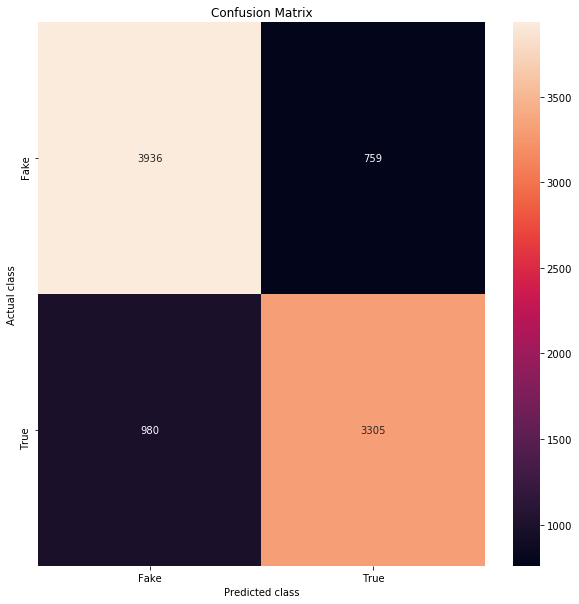

In [199]:
LABELS = ['Fake', 'True'] 
conf_matrix = confusion_matrix(y_test, prediction) 
plt.figure(figsize =(10, 10)) 
sns.heatmap(conf_matrix, xticklabels = LABELS, 
yticklabels = LABELS, annot = True, fmt ="d"); 
plt.title("Confusion Matrix") 
plt.ylabel('Actual class') 
plt.xlabel('Predicted class') 
plt.show()

In [200]:
print(classification_report(y_test, prediction))

              precision    recall  f1-score   support

        fake       0.80      0.84      0.82      4695
        true       0.81      0.77      0.79      4285

    accuracy                           0.81      8980
   macro avg       0.81      0.80      0.81      8980
weighted avg       0.81      0.81      0.81      8980



## Random Forest

In [318]:
pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', RandomForestClassifier())])

model = pipe.fit(x_train, y_train)
prediction = model.predict(x_test)
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))

accuracy: 98.9%


In [319]:
rfc_score = round(accuracy_score(y_test, prediction)*100,2)
rfc_score

98.9

In [320]:
print(confusion_matrix(y_test, prediction))

[[4650   45]
 [  54 4231]]


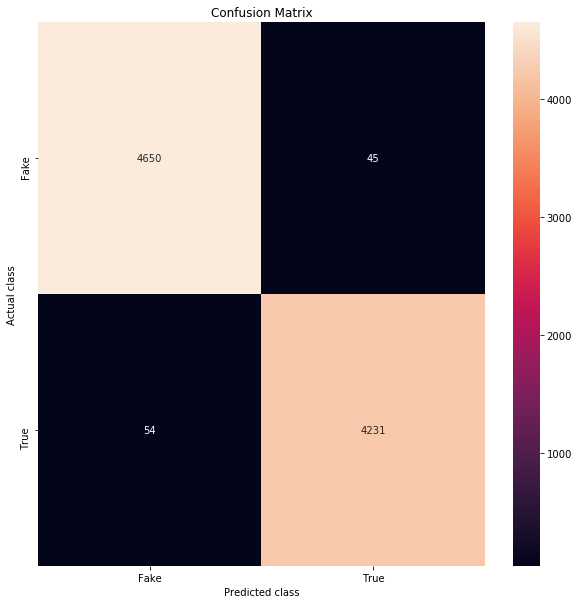

In [321]:
LABELS = ['Fake', 'True'] 
conf_matrix = confusion_matrix(y_test, prediction) 
plt.figure(figsize =(10, 10)) 
sns.heatmap(conf_matrix, xticklabels = LABELS, 
yticklabels = LABELS, annot = True, fmt ="d"); 
plt.title("Confusion Matrix") 
plt.ylabel('Actual class') 
plt.xlabel('Predicted class') 
plt.show()

In [205]:
print(classification_report(y_test, prediction))

              precision    recall  f1-score   support

        fake       0.81      0.82      0.82      4695
        true       0.80      0.79      0.79      4285

    accuracy                           0.81      8980
   macro avg       0.81      0.81      0.81      8980
weighted avg       0.81      0.81      0.81      8980



## Classifier Comparison

In [340]:
scores = {
dtc_score:'Decision Tree Classifier',
rfc_score:'Random Forest Classifier',
mnbc_score:'Multinomial Naive Bayes Classifier',
bnbc_score:'Bernoulli Naive Bayes Classifier'
}

print("Accuracy scores in percent:")
print()
print("* Decision Tree Classifier: {}%".format(dtc_score))
print("* Random Forest Classifier: {}%".format(rfc_score))
print("* Multinomial Naive Bayes Classifier: {}%".format(mnbc_score))
print("* Bernoulli Naive Bayes Classifier: {}%".format(bnbc_score))
print()
print("Best classifier is", scores[max(scores)])

Accuracy scores in percent:

* Decision Tree Classifier: 99.51%
* Random Forest Classifier: 98.9%
* Multinomial Naive Bayes Classifier: 93.65%
* Bernoulli Naive Bayes Classifier: 79.37%

Best classifier is Decision Tree Classifier


## Testing the best classifier on unknown data

In [400]:
pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', DecisionTreeClassifier(criterion= 'entropy',
                                           max_depth = 10, 
                                           splitter='best', 
                                           random_state=2020))])

model = pipe.fit(x_train, y_train)
prediction = model.predict(x_test)
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))

accuracy: 99.51%


In [401]:
# Locate a true news and a fake news
print(news.iloc[44895])
print()
print()
print(news.iloc[2])

title      Minsk cultural hub becomes haven from authorities
text       MINSK (Reuters) - In the shadow of disused Sov...
subject                                            worldnews
date                                        August 22, 2017 
target                                                  true
Name: 44895, dtype: object


title       Sheriff David Clarke Becomes An Internet Joke...
text       On Friday, it was revealed that former Milwauk...
subject                                                 News
date                                       December 30, 2017
target                                                  fake
Name: 2, dtype: object


In [402]:
# predict the two news using our model
print('Prediction of two known news articles:')
print("Known fake news:['true'] =>", model.predict([news.iloc[44895].text]))
print("Known true news:['fake'] =>", model.predict([news.iloc[2].text]))

Prediction of two known news articles:
Known fake news:['true'] => ['true']
Known true news:['fake'] => ['fake']


In [418]:
print('Unknown news prediction:', model.predict(['Reuters - Donald Trump is the president of the United States']))
print('Unknown news prediction:', model.predict(['Donald Trump is the president of the United States']))

Unknown news prediction: ['true']
Unknown news prediction: ['fake']


## Conclusion

It seems the prediction model has learned that trustworthy news organizations like Reuters, is a common factor for true news. It bases it's prediction on who the news comes from. Below we can see the trues that don't contain Reuters in the text.

In [93]:
# trues that dont contain Reuters
true_df[true_df["text"].str.contains('Reuters')==False]

title  \
0      As U.S. budget fight looms, Republicans flip t...   
1      U.S. military to accept transgender recruits o...   
2      Senior U.S. Republican senator: 'Let Mr. Muell...   
3      FBI Russia probe helped by Australian diplomat...   
4      Trump wants Postal Service to charge 'much mor...   
...                                                  ...   
21412  'Fully committed' NATO backs new U.S. approach...   
21413  LexisNexis withdrew two products from Chinese ...   
21414  Minsk cultural hub becomes haven from authorities   
21415  Vatican upbeat on possibility of Pope Francis ...   
21416  Indonesia to buy $1.14 billion worth of Russia...   

                                                    text       subject  \
0      WASHINGTON  - The head of a conservative Repub...  politicsNews   
1      WASHINGTON  - Transgender people will be allow...  politicsNews   
2      WASHINGTON  - The special counsel investigatio...  politicsNews   
3      WASHINGTON  - Trump campaign adviser George Pa...  politicsNews   
4      SEATTLE/WASHINGTON  - President Donald Trump c...  politicsNews   
...                                                  ...           ...   
21412  BRUSSELS  - NATO allies on Tuesday welcomed Pr...     worldnews   
21413  LONDON  - LexisNexis, a provider of legal, reg...     worldnews   
21414  MINSK  - In the shadow of disused Soviet-era f...     worldnews   
21415  MOSCOW  - Vatican Secretary of State Cardinal ...     worldnews   
21416  JAKARTA  - Indonesia will buy 11 Sukhoi fighte...     worldnews   

                     date target  
0      December 31, 2017    true  
1      December 29, 2017    true  
2      December 31, 2017    true  
3      December 30, 2017    true  
4      December 29, 2017    true  
...                   ...    ...  
21412    August 22, 2017    true  
21413    August 22, 2017    true  
21414    August 22, 2017    true  
21415    August 22, 2017    true  
21416    August 22, 2017    true  

[21417 rows x 5 columns]

In [94]:
# redefine true_df now without Reuters
true_df = pd.read_csv("fake-and-real-news-dataset/True.csv")
true_df['text'] = true_df['text'].map(lambda x: x.replace('(Reuters)', '').replace('Reuters', ''))
true_df

title  \
0      As U.S. budget fight looms, Republicans flip t...   
1      U.S. military to accept transgender recruits o...   
2      Senior U.S. Republican senator: 'Let Mr. Muell...   
3      FBI Russia probe helped by Australian diplomat...   
4      Trump wants Postal Service to charge 'much mor...   
...                                                  ...   
21412  'Fully committed' NATO backs new U.S. approach...   
21413  LexisNexis withdrew two products from Chinese ...   
21414  Minsk cultural hub becomes haven from authorities   
21415  Vatican upbeat on possibility of Pope Francis ...   
21416  Indonesia to buy $1.14 billion worth of Russia...   

                                                    text       subject  \
0      WASHINGTON  - The head of a conservative Repub...  politicsNews   
1      WASHINGTON  - Transgender people will be allow...  politicsNews   
2      WASHINGTON  - The special counsel investigatio...  politicsNews   
3      WASHINGTON  - Trump campaign adviser George Pa...  politicsNews   
4      SEATTLE/WASHINGTON  - President Donald Trump c...  politicsNews   
...                                                  ...           ...   
21412  BRUSSELS  - NATO allies on Tuesday welcomed Pr...     worldnews   
21413  LONDON  - LexisNexis, a provider of legal, reg...     worldnews   
21414  MINSK  - In the shadow of disused Soviet-era f...     worldnews   
21415  MOSCOW  - Vatican Secretary of State Cardinal ...     worldnews   
21416  JAKARTA  - Indonesia will buy 11 Sukhoi fighte...     worldnews   

                     date  
0      December 31, 2017   
1      December 29, 2017   
2      December 31, 2017   
3      December 30, 2017   
4      December 29, 2017   
...                   ...  
21412    August 22, 2017   
21413    August 22, 2017   
21414    August 22, 2017   
21415    August 22, 2017   
21416    August 22, 2017   

[21417 rows x 4 columns]

In [89]:
# add target identifiers to differentiate fakes and trues 
fake_df['target'] = 'fake'
true_df['target'] = 'true'

# merge the two dataframes into one
news = pd.concat([fake_df, true_df]).reset_index(drop = True)

In [90]:
Y = news.target
X = news.text
test_size = 0.20
random_state = 200

# Creating and training data
x_train,x_test,y_train,y_test = train_test_split(X, Y, test_size=test_size, random_state=random_state)

In [91]:
pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', DecisionTreeClassifier(criterion= 'entropy',
                                           max_depth = 10, 
                                           splitter='best', 
                                           random_state=2020))])

model = pipe.fit(x_train, y_train)
prediction = model.predict(x_test)
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))

accuracy: 93.18%


In [92]:
print('Unknown news prediction:', model.predict(['Reuters - Donald Trump is the president of the United States']))
print('Unknown news prediction:', model.predict(['Donald Trump is the president of the United States']))

Unknown news prediction: ['fake']
Unknown news prediction: ['fake']


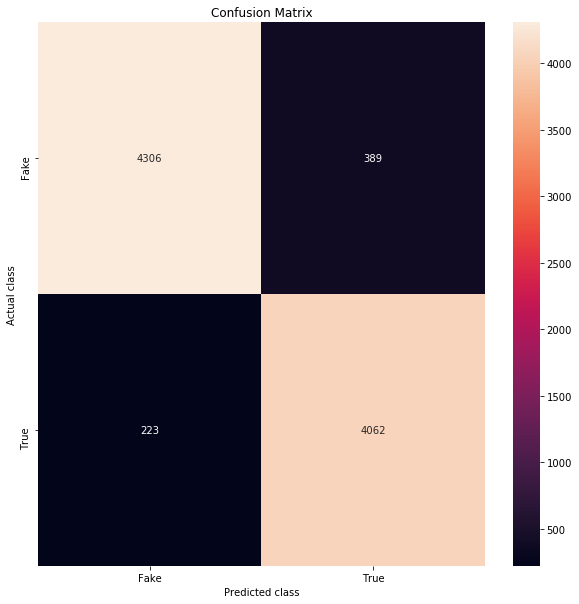

In [95]:
LABELS = ['Fake', 'True'] 
conf_matrix = confusion_matrix(y_test, prediction) 
plt.figure(figsize =(10, 10)) 
sns.heatmap(conf_matrix, xticklabels = LABELS, 
yticklabels = LABELS, annot = True, fmt ="d"); 
plt.title("Confusion Matrix") 
plt.ylabel('Actual class') 
plt.xlabel('Predicted class') 
plt.show()

## Store the trained model
Now that we know which model to use, we can save it to our local folder be using pickle

In [424]:
dtc_model_file = 'dtc_model.pkl'

# dump the model into pkl format
with open(dtc_model_file, 'wb') as f:
    pickle.dump(model, f)

In [25]:
# Load the model we pickled
with open('dtc_model.pkl', 'rb') as f:
    loaded_model = pickle.load(f)

# Test if it still works
print('Unknown news prediction:', loaded_model.predict(['Reuters - Donald Trump is the president of the United States']))

Unknown news prediction: ['true']


## WebApp

In [19]:
%%writefile app.py
from flask import Flask, render_template, request
import pickle
app = Flask(__name__)

# Load pickled model
with open('dtc_model.pkl', 'rb') as f:
    loaded_model_web = pickle.load(f)
    
@app.route("/")
def hello():
    return "Hello World!" 

@app.route('/predict', methods=['GET', 'POST'])
def index():
    name = "stranger"
    webprediction = "not predicted yet"
    source = ""
    newsstory = ""
    
    if request.method == 'POST' and 'name' in request.form:
        name = request.form['name']
        
    if request.method == 'POST' and 'source' in request.form:
        source = request.form['source']
        
    if request.method == 'POST' and 'newsstory' in request.form:
        newsstory = request.form['newsstory']
        
    if request.method == 'POST' and 'newsstory' and 'source' in request.form:
        webprediction = loaded_model_web.predict([source + " " + newsstory])[0]
    
    return render_template('index.html', name=name, webprediction=webprediction, source=source, newsstory=newsstory)

if __name__ == "__main__":
    app.run()

Overwriting app.py


In [ ]:
# run web app on the server
!python app.py

### Links to webapp
* ### [hello world](http://localhost:5000/)
* ### [fake news detector](http://localhost:5000/predict)
